## Part 3 — Integration of Image Data

### Imports

In [34]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

# Plotting utilities for Part 3
from part3_utils import *

best_mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        activation="relu",
        alpha=0.01,
        hidden_layer_sizes=(200, 150),
        learning_rate_init=0.016,
        solver="adam",
        max_iter=30,           # increase for stability on combined features
        random_state=42,
        early_stopping=True,     # helps prevent overfitting
        n_iter_no_change=20,
        validation_fraction=0.1
    ))
])


import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Negative RMSE for sklearn scorers (because sklearn maximizes scores)
neg_rmse_scorer = make_scorer(lambda yt, yp: -rmse(yt, yp))

In [35]:
class CustomImageDataset(Dataset):
    def __init__(self, images, images_directory, target=None, transform=None):
        self.images = list(images)
        self.images_directory = images_directory
        self.target = None if target is None else np.asarray(target).reshape(-1)
        if transform is None:
            transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_directory, self.images[idx])
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        if self.target is not None:
            return image, float(self.target[idx])
        else:
            return image

In [36]:
class SimpleCNN(nn.Module):
    def __init__(self, n_features):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # 48x48 -> 24x24 -> 12x12 with 8 channels -> 8*12*12
        self.fc1 = nn.Linear(8*12*12, n_features)
        self.fc2 = nn.Linear(n_features, 1)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 8*12*12)
        features = self.fc1(x)
        out = self.fc2(features)
        return out, features

In [37]:

class MyCNN:
    def __init__(self, n_features=8, n_epochs=20, batch_size=50, learning_rate=5e-4, device=None):
        self.n_features = n_features
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.history = None
        self.best_state_dict = None
        self.best_val_rmse = np.inf
        self.best_epoch = -1

    def fit(self, images, y, data_dir):
        # Simple internal train/val split (75/25)
        split_ratio = 0.75
        split_index = int(len(images) * split_ratio)
        images_train = images[:split_index]
        y_train = y[:split_index]
        images_val = images[split_index:]
        y_val = y[split_index:]

        train_dataset = CustomImageDataset(images_train, data_dir, y_train)
        val_dataset = CustomImageDataset(images_val, data_dir, y_val)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

        self.model = SimpleCNN(n_features=self.n_features).to(self.device)
        criterion = nn.MSELoss(reduction='mean')
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

        self.history = {"epoch": [], "train_rmse": [], "val_rmse": []}

        for epoch in range(self.n_epochs):
            # Train
            self.model.train()
            running_loss = 0.0
            for i, (inputs, labels) in enumerate(train_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs, _ = self.model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            train_rmse = np.sqrt(running_loss / max(1, (i+1)))

            # Validate
            self.model.eval()
            running_loss_val = 0.0
            with torch.no_grad():
                for j, (inputs, labels) in enumerate(val_loader):
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    outputs, _ = self.model(inputs)
                    loss = criterion(outputs.squeeze(), labels.float())
                    running_loss_val += loss.item()
            val_rmse = np.sqrt(running_loss_val / max(1, (j+1)))

            # Log
            self.history["epoch"].append(epoch + 1)
            self.history["train_rmse"].append(train_rmse)
            self.history["val_rmse"].append(val_rmse)

            # Track best
            if val_rmse < self.best_val_rmse:
                self.best_val_rmse = val_rmse
                self.best_epoch = epoch + 1
                self.best_state_dict = deepcopy(self.model.state_dict())

            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1:2d} | Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f}")

        # Optionally restore best weights
        if self.best_state_dict is not None:
            self.model.load_state_dict(self.best_state_dict)

        return self.history

    def predict(self, images, data_dir):
        dataset = CustomImageDataset(images, data_dir)
        loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
        self.model.eval()
        preds = []
        with torch.no_grad():
            for batch in loader:
                batch = batch.to(self.device)
                out, _ = self.model(batch)
                preds.append(out.squeeze().cpu().numpy())
        return np.concatenate(preds, axis=0)

    def extract_features(self, images, data_dir):
        dataset = CustomImageDataset(images, data_dir)
        loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
        self.model.eval()
        feats = []
        with torch.no_grad():
            for batch in loader:
                batch = batch.to(self.device)
                _, features = self.model(batch)
                feats.append(features.cpu().numpy())
        return np.concatenate(feats, axis=0)

Samples: 1000 | Tabular dims: 9 | Images: 1000
Train: (800, 9), Test: (200, 9)
t-SNE on pixel values


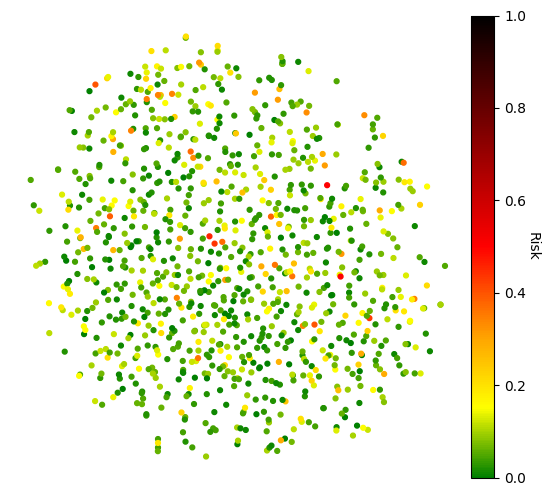

In [38]:
X_df = pd.read_csv("../data/data_labeled/X_train.csv")
y_df = pd.read_csv("../data/data_labeled/y_train.csv", header=None, names=["risk"])

assert "img_filename" in X_df.columns, "Expected column 'img_filename' in X_train.csv"

# Separate image filenames and tabular features
img_filenames = X_df["img_filename"].astype(str).values
X_tabular = X_df.drop(columns=["img_filename"])

# Keep only numeric columns to feed MLP
X_tabular = X_tabular.select_dtypes(include=[np.number])

y = y_df["risk"].values.reshape(-1)

print(f"Samples: {len(X_df)} | Tabular dims: {X_tabular.shape[1]} | Images: {len(img_filenames)}")

# Train/test split (aligned between tabular, images, and targets)
X_tab_train, X_tab_test, img_train, img_test, y_train, y_test = train_test_split(
    X_tabular.values, img_filenames, y, test_size=0.2, random_state=RANDOM_STATE, stratify=None
)

print(f"Train: {X_tab_train.shape}, Test: {X_tab_test.shape}")

dataset_viz = CustomImageDataset(
    images=img_filenames, 
    images_directory="../data/data_labeled/Img_train", 
    target=y
)
print("t-SNE on pixel values")
visualize_dataset_tSNE(dataset_viz, extract_features=False, perplexity=30, random_state=42, zoom=2.0)


Epoch  5 | Train RMSE: 0.0833 | Val RMSE: 0.0819
Epoch 10 | Train RMSE: 0.0763 | Val RMSE: 0.0778
Epoch 15 | Train RMSE: 0.0686 | Val RMSE: 0.0748
Epoch 20 | Train RMSE: 0.0623 | Val RMSE: 0.0760
Epoch 25 | Train RMSE: 0.0598 | Val RMSE: 0.0718
Epoch 30 | Train RMSE: 0.0564 | Val RMSE: 0.0717
Epoch 35 | Train RMSE: 0.0539 | Val RMSE: 0.0716
Epoch 40 | Train RMSE: 0.0515 | Val RMSE: 0.0721
Epoch 45 | Train RMSE: 0.0499 | Val RMSE: 0.0740
Epoch 50 | Train RMSE: 0.0516 | Val RMSE: 0.0740
Epoch 55 | Train RMSE: 0.0463 | Val RMSE: 0.0741
Epoch 60 | Train RMSE: 0.0456 | Val RMSE: 0.0747
Extracted image features:
Z_train: (800, 8) Z_test: (200, 8)


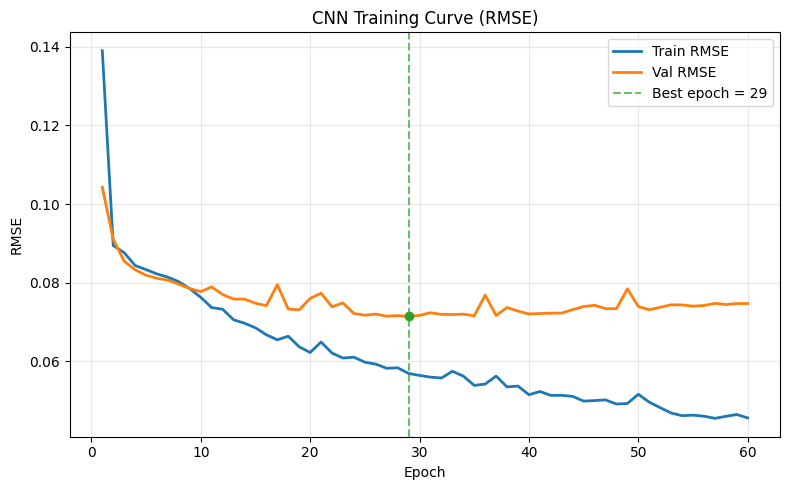

In [39]:
IMAGE_DIR = "../data/data_labeled/Img_train"
N_FEATURES = 8  # dimension of image-derived feature vector

cnn = MyCNN(n_features=N_FEATURES, n_epochs=60, batch_size=50, learning_rate=5e-4)
history = cnn.fit(images=img_train, y=y_train, data_dir=IMAGE_DIR)

# Extract features for train and test
Z_train = cnn.extract_features(images=img_train, data_dir=IMAGE_DIR)  # shape (n_train, N_FEATURES)
Z_test  = cnn.extract_features(images=img_test,  data_dir=IMAGE_DIR)  # shape (n_test,  N_FEATURES)

print("Extracted image features:")
print("Z_train:", Z_train.shape, "Z_test:", Z_test.shape)

plot_cnn_training_curves(
    history, 
    best_epoch=cnn.best_epoch, 
    best_val_rmse=cnn.best_val_rmse, 
    title="CNN Training Curve (RMSE)"
)


t-SNE on extracted CNN features


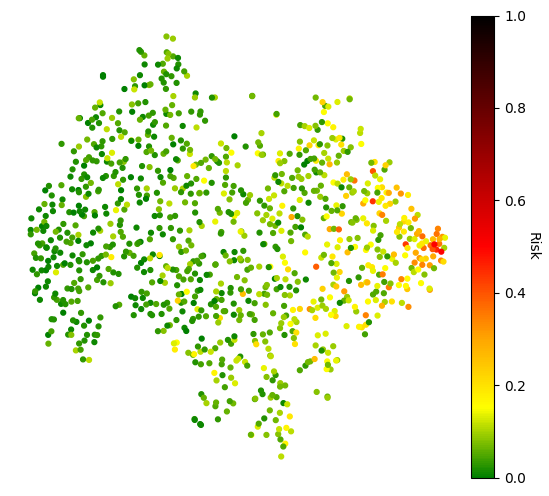

In [40]:
print("t-SNE on extracted CNN features")
visualize_dataset_tSNE(dataset_viz, extract_features=True, feature_extractor=cnn, perplexity=30, random_state=42, zoom=2.0)

In [41]:
# Tabular-only baseline
best_mlp.fit(X_tab_train, y_train)
y_pred_tab = best_mlp.predict(X_tab_test)
rmse_tab_test = rmse(y_test, y_pred_tab)

print("Tabular-only MLP:")
print(f"  Test RMSE: {rmse_tab_test:.4f}")

Tabular-only MLP:
  Test RMSE: 0.0421


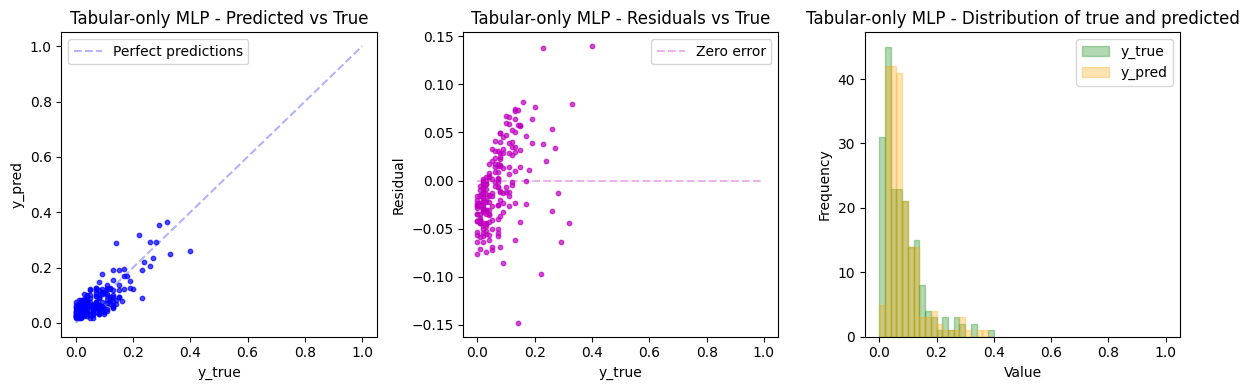

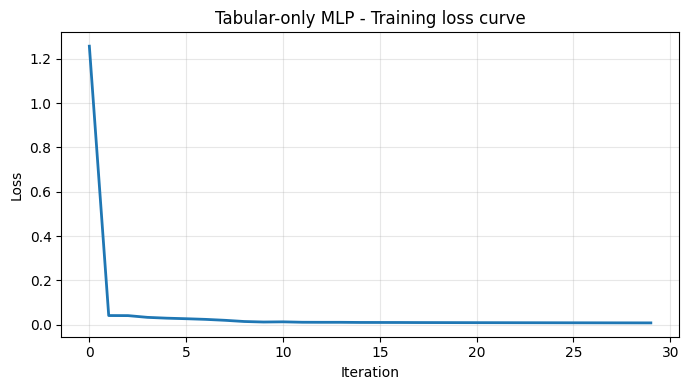

In [42]:
# Residual/error analysis for tabular-only model
visualize_regression_results(y_test, y_pred_tab, title_prefix="Tabular-only MLP - ")

# Optional: training loss curve for the fitted MLPRegressor
plot_mlp_loss_curve(best_mlp, title="Tabular-only MLP - Training loss curve")

Combined shapes: (800, 17) (200, 17)

Tabular + Image MLP:
  Test RMSE: 0.0401


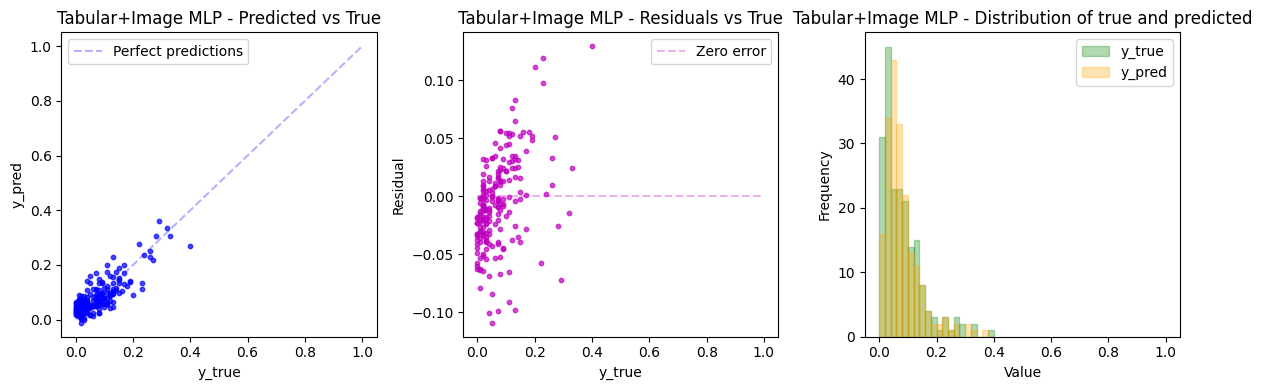

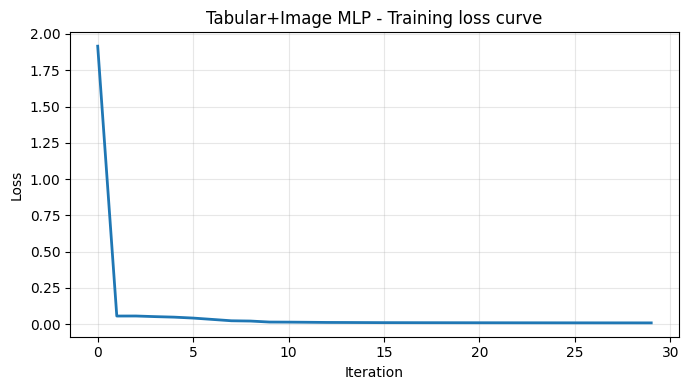

In [43]:
# Combine tabular and image features
X_comb_train = np.hstack([X_tab_train, Z_train])
X_comb_test  = np.hstack([X_tab_test,  Z_test])
print("Combined shapes:", X_comb_train.shape, X_comb_test.shape)

best_mlp.fit(X_comb_train, y_train)
y_pred_comb = best_mlp.predict(X_comb_test)
rmse_comb_test = rmse(y_test, y_pred_comb)

print("\nTabular + Image MLP:")
print(f"  Test RMSE: {rmse_comb_test:.4f}")

# Residual/error analysis for combined model
visualize_regression_results(y_test, y_pred_comb, title_prefix="Tabular+Image MLP - ")

# Optional: training loss curve for the fitted MLPRegressor (after combined fit)
plot_mlp_loss_curve(best_mlp, title="Tabular+Image MLP - Training loss curve")

In [44]:
print("\n=======================================================")
print("Final Test Comparison (lower RMSE is better)")
print("-------------------------------------------------------")
print(f"Tabular-only MLP     : {rmse_tab_test:.4f}")
print(f"Tabular+Image MLP    : {rmse_comb_test:.4f}")
print("=======================================================")

improvement = rmse_tab_test - rmse_comb_test
print(f"Absolute improvement (RMSE): {improvement:+.4f}")


Final Test Comparison (lower RMSE is better)
-------------------------------------------------------
Tabular-only MLP     : 0.0421
Tabular+Image MLP    : 0.0401
Absolute improvement (RMSE): +0.0020


In [45]:
def extract_engineered_kernel_features(image_filenames, image_dir, kernels_dict, 
                                       include_unsharp=True, include_dog=True,
                                       dog_params=(1.0, 2.5), unsharp_alpha=1.0):
    """
    Returns: np.ndarray shape (n_samples, n_features)
             feature_names list
    For each kernel response we compute: mean, std, energy, variance, entropy.
    If include_unsharp / include_dog, we add those responses similarly.
    """
    stats_keys = ["mean", "std", "energy", "variance", "entropy"]
    feature_names = []
    rows = []

    for fname in image_filenames:
        path = os.path.join(image_dir, fname)
        img = Image.open(path).convert("L")
        img_np = np.array(img, dtype=float)
        # Normalize image to [0,1]
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)
        torch_img = torch.tensor(img_np, dtype=torch.float32).unsqueeze(0)

        row_feats = []

        # Convolution kernels
        for kname, kmat in kernels_dict.items():
            resp = apply_conv_kernel(torch_img, kmat)
            m = response_stats(resp)
            for sk in stats_keys:
                feature_names.append(f"{kname}_{sk}")
                row_feats.append(m[sk])

        # Unsharp
        if include_unsharp:
            us = unsharp(img_np, alpha=unsharp_alpha)
            m_us = response_stats(us)
            for sk in stats_keys:
                feature_names.append(f"unsharp_{sk}")
                row_feats.append(m_us[sk])

        # DoG
        if include_dog:
            dog_resp = dog(img_np, sigma_small=dog_params[0], sigma_big=dog_params[1])
            m_dog = response_stats(dog_resp)
            for sk in stats_keys:
                feature_names.append(f"dog_{sk}")
                row_feats.append(m_dog[sk])

        rows.append(row_feats)

    # feature_names repeated per image; need only once in correct order
    # We built them cumulatively; they repeat for each image.
    # Fix: compute once using first image logic.
    per_image_feature_count = len(rows[0])
    # The appended feature_names length = per_image_feature_count * n_images; slice first chunk:
    feature_names = feature_names[:per_image_feature_count]

    return np.array(rows), feature_names

# Extract engineered features for train / test
kernel_train_feats, kernel_feature_names = extract_engineered_kernel_features(
    img_train, IMAGE_DIR, KERNEL_BANK,
    include_unsharp=True,
    include_dog=True,
    dog_params=(1.0, 2.5),
    unsharp_alpha=1.2
)

kernel_test_feats, _ = extract_engineered_kernel_features(
    img_test, IMAGE_DIR, KERNEL_BANK,
    include_unsharp=True,
    include_dog=True,
    dog_params=(1.0, 2.5),
    unsharp_alpha=1.2
)

print("Kernel engineered feature shape (train):", kernel_train_feats.shape)
print("Kernel engineered feature shape (test) :", kernel_test_feats.shape)
print("Sample feature names (first 10):", kernel_feature_names[:10])

Kernel engineered feature shape (train): (800, 55)
Kernel engineered feature shape (test) : (200, 55)
Sample feature names (first 10): ['blur_soft_mean', 'blur_soft_std', 'blur_soft_energy', 'blur_soft_variance', 'blur_soft_entropy', 'sharpen_mean', 'sharpen_std', 'sharpen_energy', 'sharpen_variance', 'sharpen_entropy']


In [46]:
from sklearn.base import clone

def eval_single_kernel(kernel_name, kernel_mat):
    """
    Adds engineered stats from a single kernel to the existing
    Tabular+Image features (X_comb_*) and returns test RMSE.
    """
    # Build a single-kernel dict
    kernels_dict = {kernel_name: kernel_mat}

    # Extract features for train/test with ONLY this kernel (no unsharp/DoG here)
    feats_train, _ = extract_engineered_kernel_features(
        img_train, IMAGE_DIR, kernels_dict,
        include_unsharp=False, include_dog=False
    )
    feats_test, _ = extract_engineered_kernel_features(
        img_test, IMAGE_DIR, kernels_dict,
        include_unsharp=False, include_dog=False
    )

    # Augment Tabular+Image (CNN) with this kernel’s features
    X_single_train = np.hstack([X_comb_train, feats_train])
    X_single_test  = np.hstack([X_comb_test,  feats_test])

    # Clone the MLP so we don’t reuse state
    model = clone(best_mlp)
    # Make sure we allow enough iterations for the larger feature space
    model.set_params(mlp__max_iter=2000)
    model.fit(X_single_train, y_train)
    y_pred = model.predict(X_single_test)
    return rmse(y_test, y_pred)

Baseline Tabular+Image RMSE: 0.0401

=== Kernel: blur_soft ===


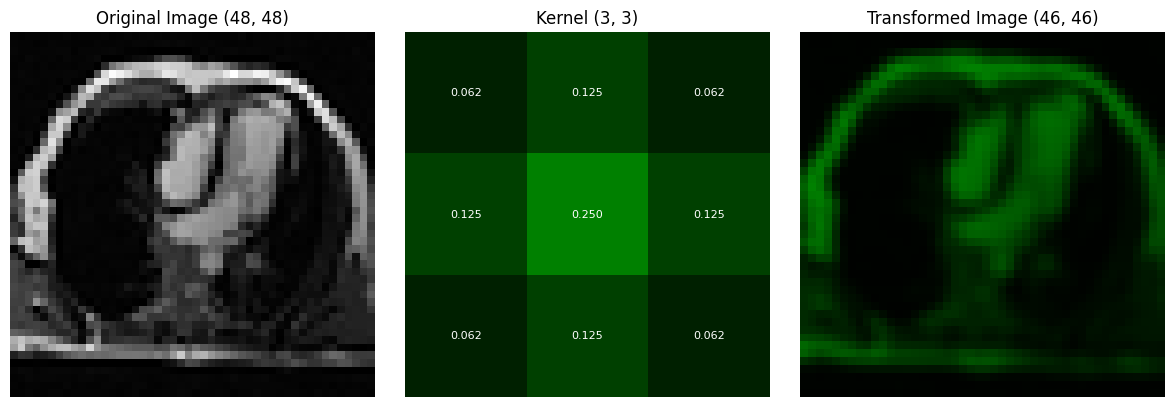

Tabular+Image+blur_soft RMSE: 0.0404  (Δ vs baseline: -0.0003)

=== Kernel: sharpen ===


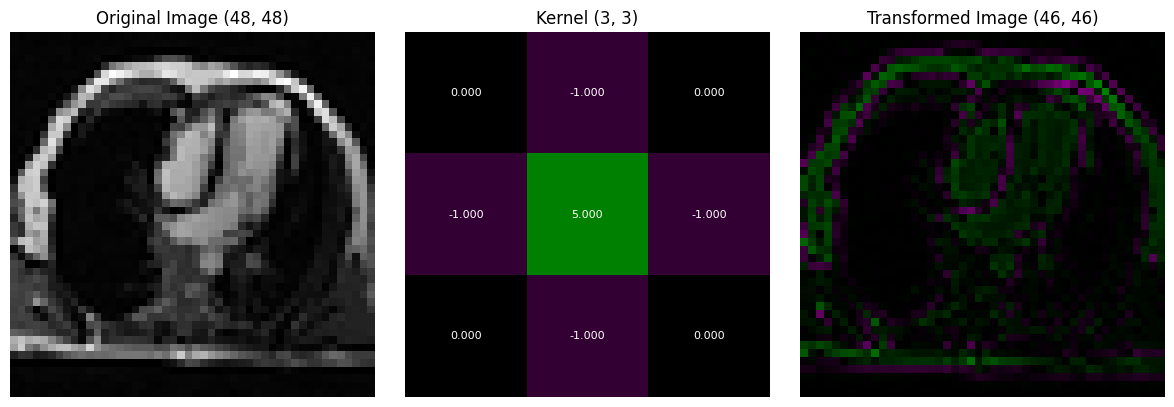

Tabular+Image+sharpen RMSE: 0.0396  (Δ vs baseline: +0.0005)

=== Kernel: laplacian_4 ===


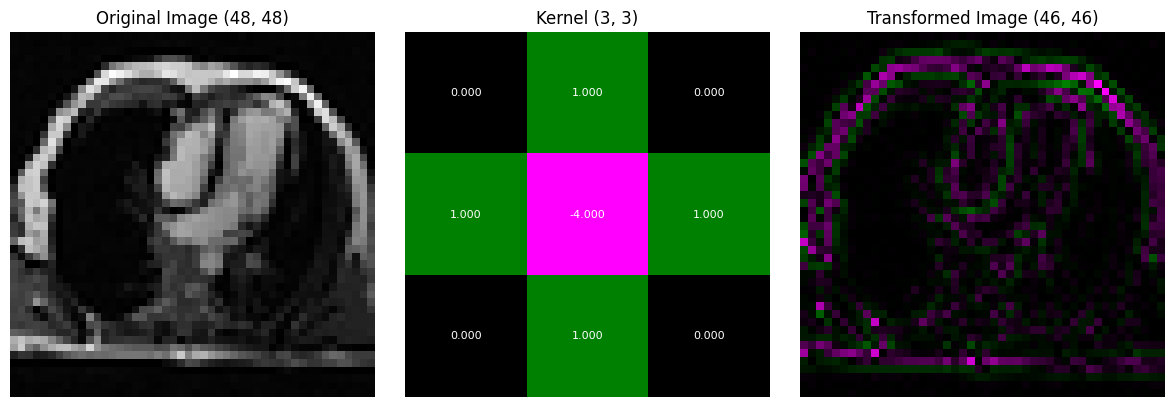

Tabular+Image+laplacian_4 RMSE: 0.0384  (Δ vs baseline: +0.0017)

=== Kernel: laplacian_8 ===


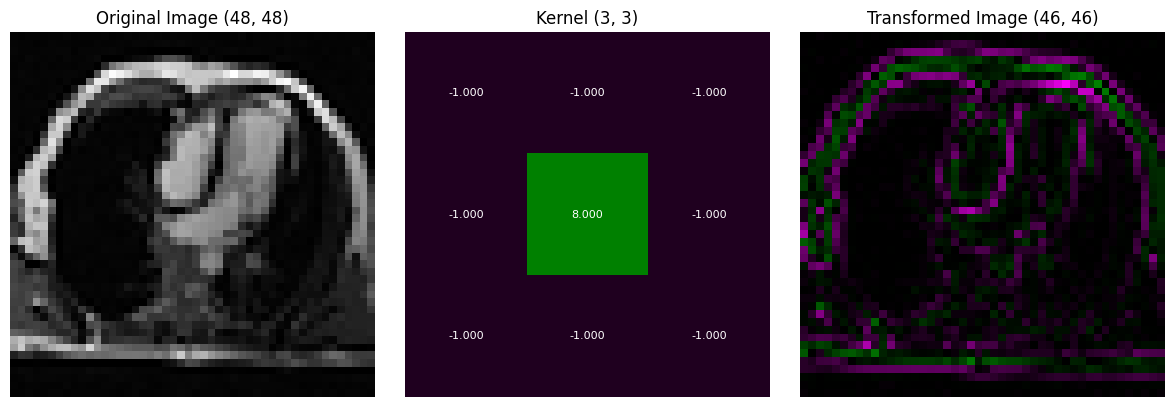

Tabular+Image+laplacian_8 RMSE: 0.0403  (Δ vs baseline: -0.0001)

=== Kernel: sobel_x ===


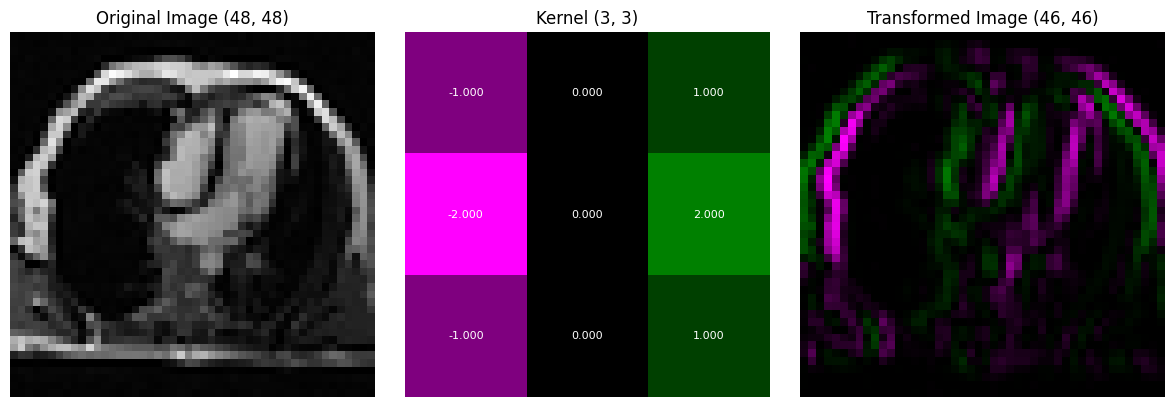

Tabular+Image+sobel_x RMSE: 0.0402  (Δ vs baseline: -0.0001)

=== Kernel: sobel_y ===


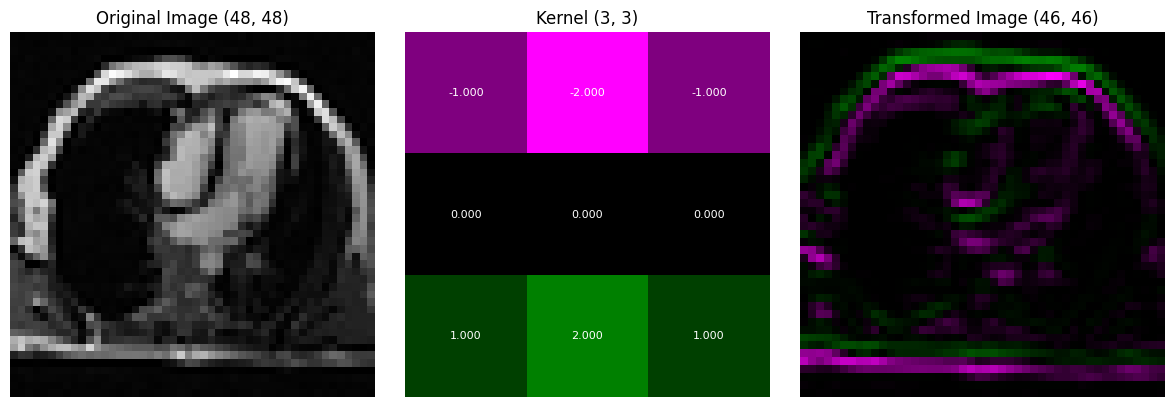

Tabular+Image+sobel_y RMSE: 0.0444  (Δ vs baseline: -0.0043)

=== Kernel: scharr_x ===


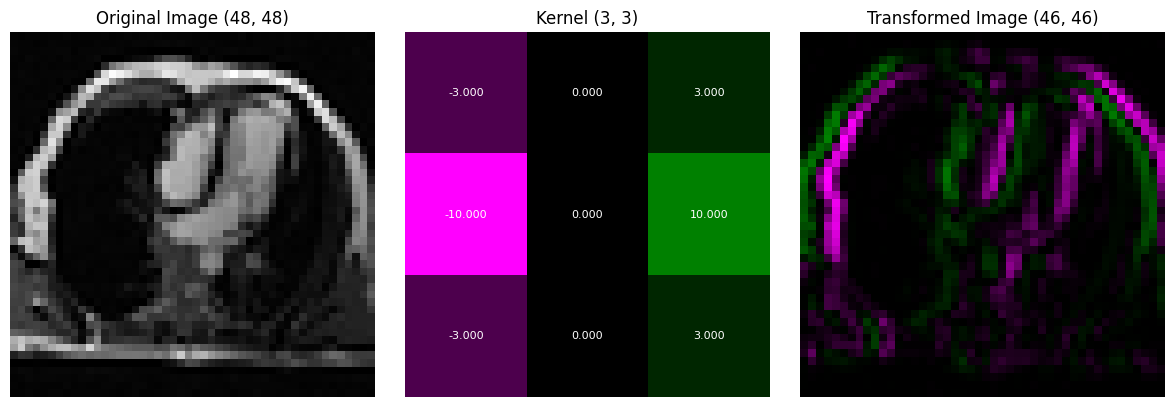

Tabular+Image+scharr_x RMSE: 0.0401  (Δ vs baseline: +0.0000)

=== Kernel: scharr_y ===


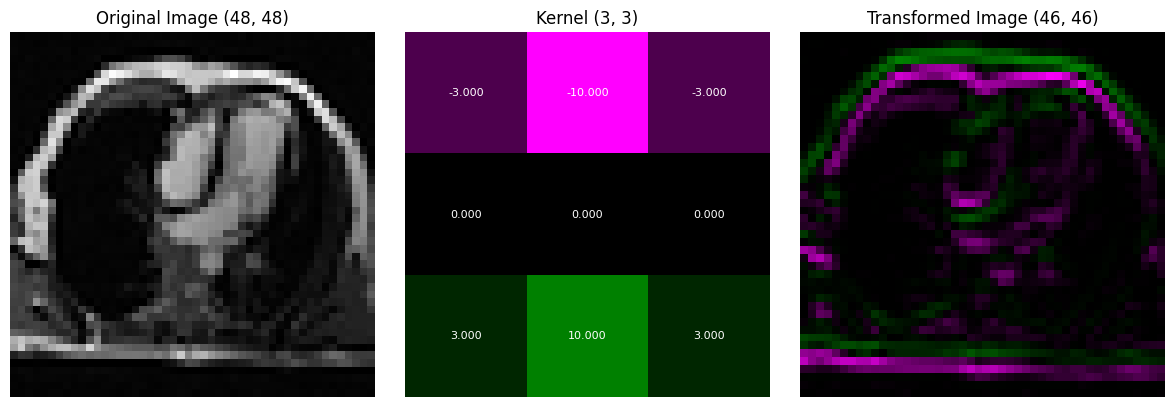

Tabular+Image+scharr_y RMSE: 0.0403  (Δ vs baseline: -0.0002)

=== Kernel: emboss ===


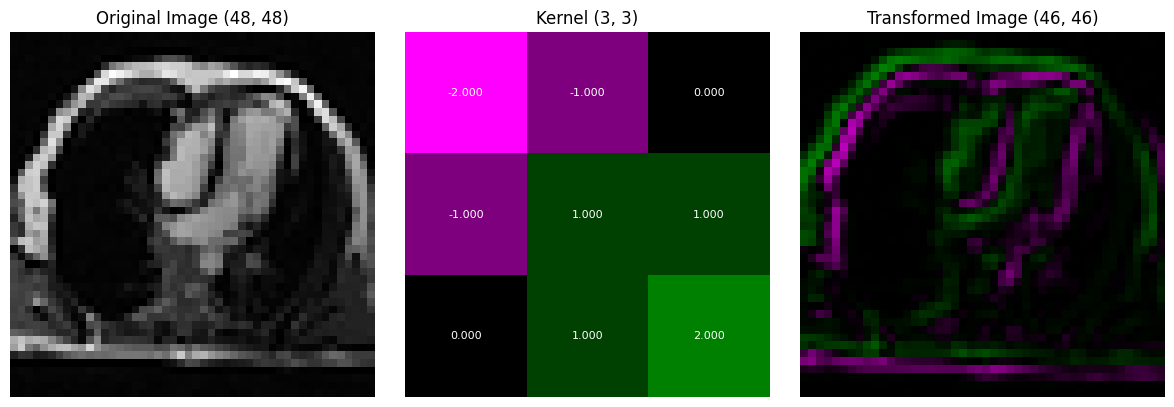

Tabular+Image+emboss RMSE: 0.0389  (Δ vs baseline: +0.0013)

=== Summary (lower is better) ===
laplacian_4  -> RMSE: 0.0384 (Δ vs baseline: +0.0017)
emboss       -> RMSE: 0.0389 (Δ vs baseline: +0.0013)
sharpen      -> RMSE: 0.0396 (Δ vs baseline: +0.0005)
scharr_x     -> RMSE: 0.0401 (Δ vs baseline: +0.0000)
sobel_x      -> RMSE: 0.0402 (Δ vs baseline: -0.0001)
laplacian_8  -> RMSE: 0.0403 (Δ vs baseline: -0.0001)
scharr_y     -> RMSE: 0.0403 (Δ vs baseline: -0.0002)
blur_soft    -> RMSE: 0.0404 (Δ vs baseline: -0.0003)
sobel_y      -> RMSE: 0.0444 (Δ vs baseline: -0.0043)

>>> BEST KERNEL: laplacian_4 (RMSE = 0.0384)


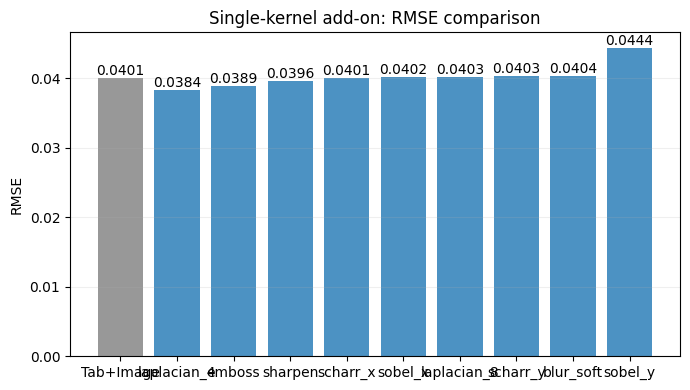

In [47]:
# Pick a single sample image to visualize the convolution result consistently
# We use the same dataset_viz you already created
sample_idx = 20
sample_image, _ = dataset_viz[sample_idx]  # torch tensor (1,H,W) due to transform

kernel_rmse_results = []

print(f"Baseline Tabular+Image RMSE: {rmse_comb_test:.4f}\n")

for kname, kmat in KERNEL_BANK.items():
    print(f"=== Kernel: {kname} ===")
    # 1) Visualize the convolution result on the sample image
    visualize_2Dconvolution(sample_image.clone(), kmat)

    # 2) Evaluate its impact on Tabular+Image (CNN) performance
    r = eval_single_kernel(kname, kmat)
    kernel_rmse_results.append((kname, r))
    print(f"Tabular+Image+{kname} RMSE: {r:.4f}  (Δ vs baseline: {rmse_comb_test - r:+.4f})\n")

# Sort and display summary
kernel_rmse_results = sorted(kernel_rmse_results, key=lambda x: x[1])
print("=== Summary (lower is better) ===")
for name, r in kernel_rmse_results:
    print(f"{name:12s} -> RMSE: {r:.4f} (Δ vs baseline: {rmse_comb_test - r:+.4f})")

# Store the best kernel
best_kernel_name, best_kernel_rmse = kernel_rmse_results[0]
BEST_KERNEL_NAME = best_kernel_name
BEST_KERNEL_MATRIX = KERNEL_BANK[best_kernel_name]
print(f"\n>>> BEST KERNEL: {BEST_KERNEL_NAME} (RMSE = {best_kernel_rmse:.4f})")

# Plot comparison
labels = ["Tab+Image"] + [name for name, _ in kernel_rmse_results]
values = [rmse_comb_test] + [r for _, r in kernel_rmse_results]
plot_rmse_comparison(dict(zip(labels, values)), title="Single-kernel add-on: RMSE comparison")



In [ ]:
# Build engineered features with ONLY the best kernel for train/test
best_train_feats, best_feat_names = extract_engineered_kernel_features(
    img_train, IMAGE_DIR, {BEST_KERNEL_NAME: BEST_KERNEL_MATRIX},
    include_unsharp=False, include_dog=False
)
best_test_feats, _ = extract_engineered_kernel_features(
    img_test, IMAGE_DIR, {BEST_KERNEL_NAME: BEST_KERNEL_MATRIX},
    include_unsharp=False, include_dog=False
)

print("Best-kernel engineered feature shape (train/test):", best_train_feats.shape, best_test_feats.shape)

# For the rest of the analysis, define augmented features based on BEST KERNEL
# This will be used by subsequent cells as the "Tabular+Image+Kernel" variant
X_aug_train = np.hstack([X_comb_train, best_train_feats])
X_aug_test  = np.hstack([X_comb_test,  best_test_feats])

# Fit an augmented MLP using only the best kernel features
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

augmented_mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        activation="relu",
        alpha=0.01,
        hidden_layer_sizes=(200, 150),
        learning_rate_init=0.016,
        solver="adam",
        max_iter=30,
        random_state=42,
        early_stopping=True,
        n_iter_no_change=20,
        validation_fraction=0.1
    ))
])

augmented_mlp.fit(X_aug_train, y_train)
y_pred_aug = augmented_mlp.predict(X_aug_test)
rmse_aug_test = rmse(y_test, y_pred_aug)

print("\nTabular + Image + BEST Kernel MLP:")
print(f"  BEST KERNEL: {BEST_KERNEL_NAME}")
print(f"  Test RMSE:   {rmse_aug_test:.4f}")

Best-kernel engineered feature shape (train/test): (800, 5) (200, 5)

Tabular + Image + BEST Kernel MLP:
  BEST KERNEL: laplacian_4
  Test RMSE:   0.0384


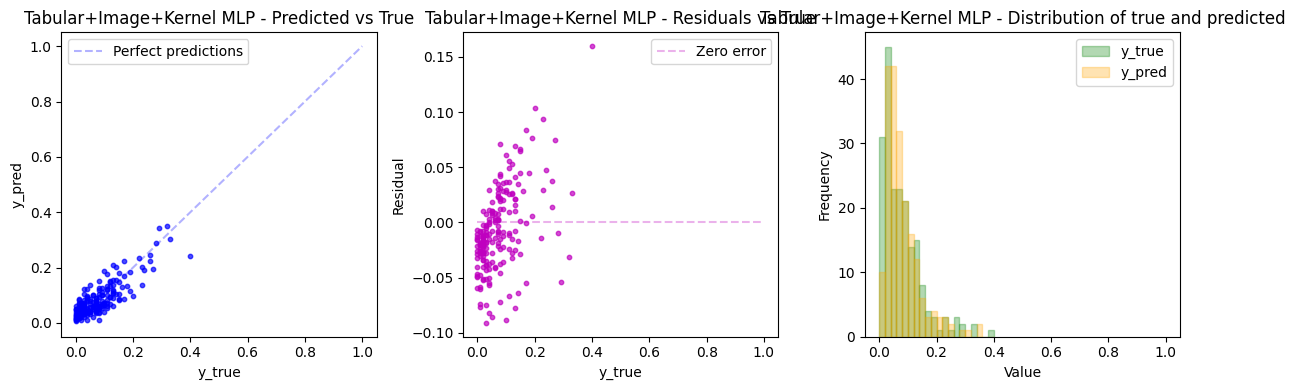

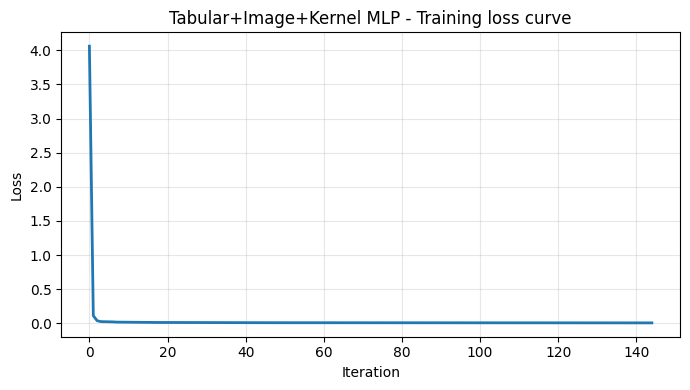

In [49]:
visualize_regression_results(y_test, y_pred_aug, title_prefix="Tabular+Image+Kernel MLP - ")
plot_mlp_loss_curve(augmented_mlp, title="Tabular+Image+Kernel MLP - Training loss curve")

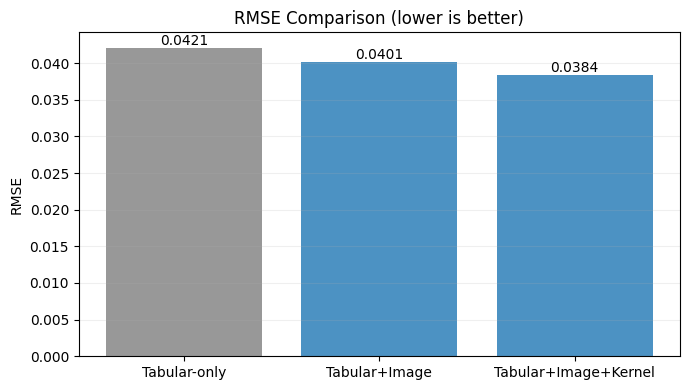

Absolute improvement Tabular+Image+Kernel vs Tabular-only: +0.0037
Absolute improvement Tabular+Image+Kernel vs Tabular+Image: +0.0017


In [50]:
plot_rmse_comparison(
    {
        "Tabular-only": rmse_tab_test,
        "Tabular+Image": rmse_comb_test,
        "Tabular+Image+Kernel": rmse_aug_test
    },
    title="RMSE Comparison (lower is better)"
)

print("Absolute improvement Tabular+Image+Kernel vs Tabular-only:",
      f"{rmse_tab_test - rmse_aug_test:+.4f}")
print("Absolute improvement Tabular+Image+Kernel vs Tabular+Image:",
      f"{rmse_comb_test - rmse_aug_test:+.4f}")